# Laplace equation

$$
\nabla^2 u = 0
$$


In [11]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

First a very easy case with the analytical solution u = x

Epoch 0, Total Loss: 4.960E+01, Domain Loss: 9.178E-04, Boundary Loss Dirichlet: 7.917E-02


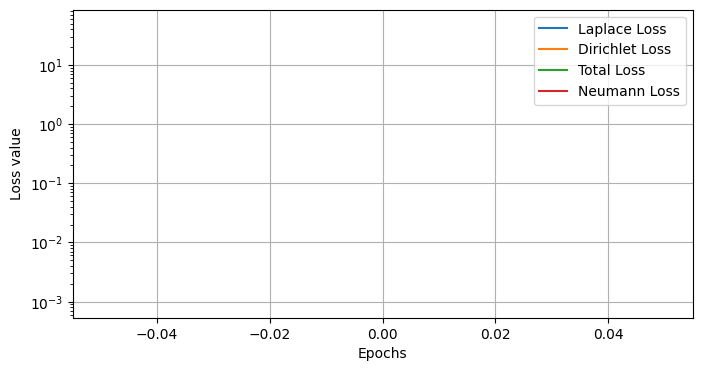

Epoch 10, Total Loss: 1.574E-02, Domain Loss: 1.139E-06, Boundary Loss Dirichlet: 5.295E-07


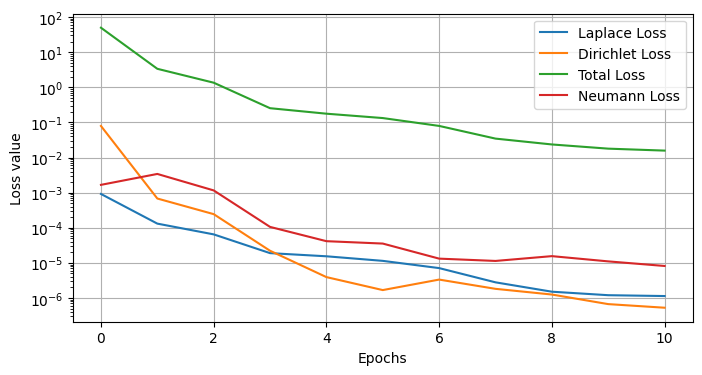

Epoch 20, Total Loss: 3.669E-04, Domain Loss: 3.386E-08, Boundary Loss Dirichlet: 8.123E-09


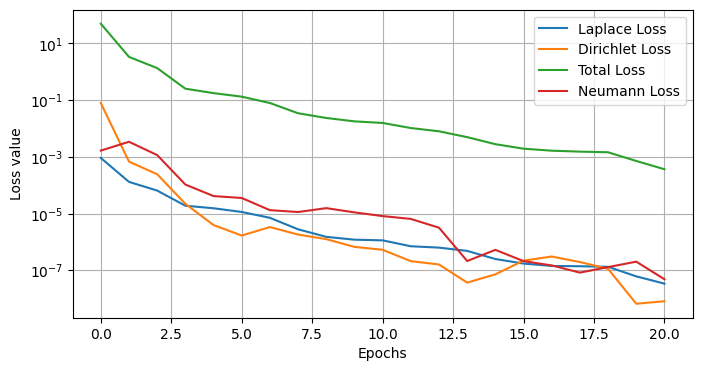

Epoch 30, Total Loss: 1.202E-04, Domain Loss: 1.095E-08, Boundary Loss Dirichlet: 1.429E-08


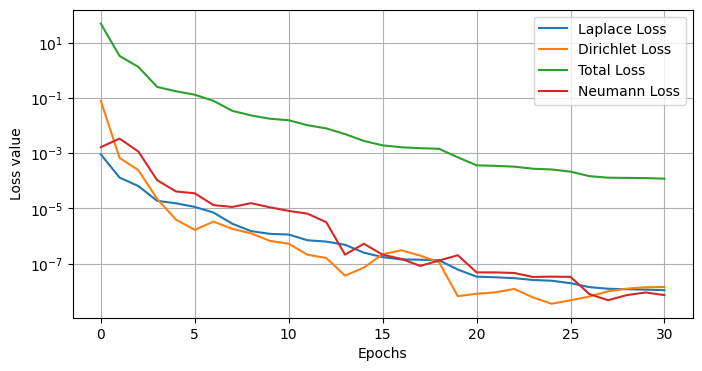

Epoch 40, Total Loss: 7.592E-05, Domain Loss: 7.262E-09, Boundary Loss Dirichlet: 4.303E-10


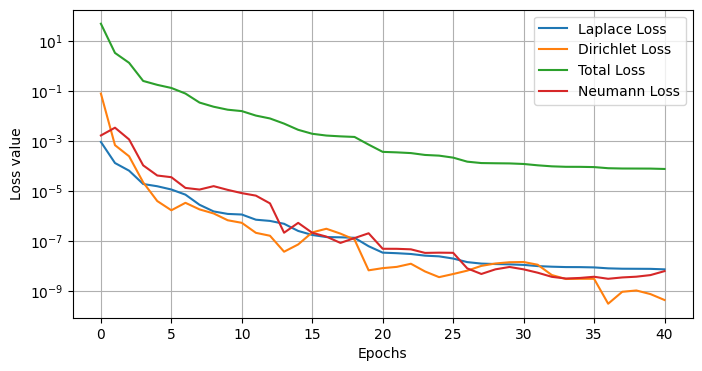

Epoch 50, Total Loss: 2.377E-05, Domain Loss: 1.427E-09, Boundary Loss Dirichlet: 2.326E-09


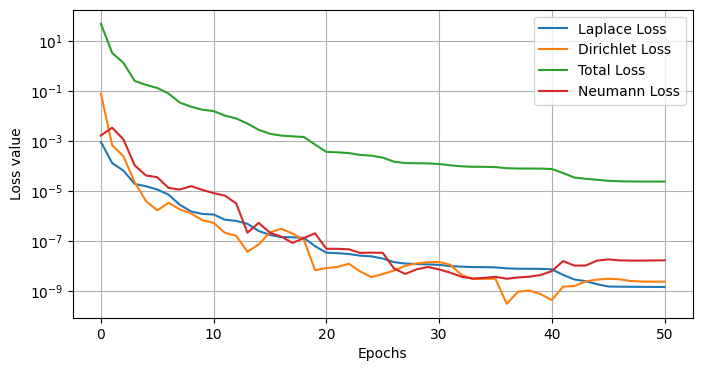

Epoch 60, Total Loss: 1.256E-05, Domain Loss: 9.326E-10, Boundary Loss Dirichlet: 3.393E-09


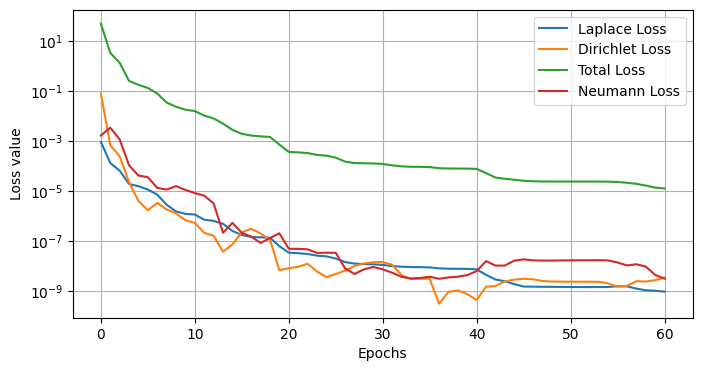

Epoch 70, Total Loss: 5.294E-06, Domain Loss: 4.395E-10, Boundary Loss Dirichlet: 5.231E-10


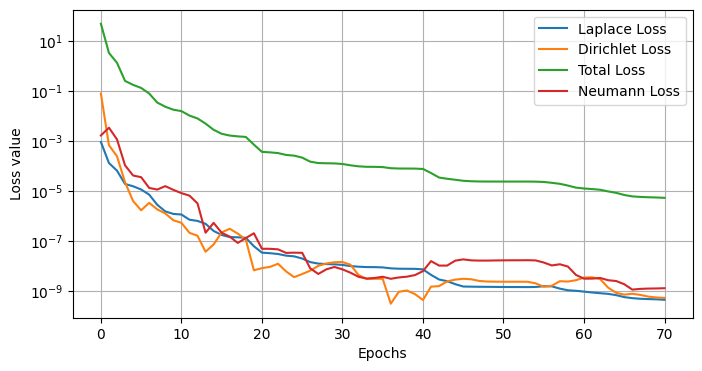

In [436]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points
    
def plot_losses(epochs, laplace_losses, dirichlet_losses, neumann_losses, total_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, laplace_losses, label="Laplace Loss")
    plt.plot(epochs, dirichlet_losses, label="Dirichlet Loss")
    plt.plot(epochs, total_losses, label="Total Loss")
    plt.plot(epochs, neumann_losses, label="Neumann Loss")
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()
#_____________________________________________________________________________________________________________

# Boundary points and targets storage
boundary_points_dirichlet = []
boundary_target_dirichlet = []
boundary_points_neumann = []

# Dirichlet boundary conditions
dirichlet_boundaries = [
    ('vertical', 0, 0, 1, 1000, 0),  # Left boundary
    ('vertical', 1, 0, 1, 1000, 1),  # Right boundary
    # ('horizontal', 0, 0, 1, 100, 1),  # Bottom boundary
    # ('horizontal', 1, 0, 1, 100, 0)   # Top boundary
]

for axis, place, start, end, num_points, head in dirichlet_boundaries:
    boundary_points, boundary_targets = create_boundary_points(axis, place, start, end, num_points, head)
    boundary_points_dirichlet.append(boundary_points)
    boundary_target_dirichlet.append(boundary_targets)

# Concatenate Dirichlet boundary points and targets
boundary_points_dirichlet = torch.cat(boundary_points_dirichlet, dim=0).requires_grad_(True)
boundary_target_dirichlet = torch.cat(boundary_target_dirichlet, dim=0)

# Neumann boundary conditions
neumann_boundaries = [
    # ('vertical', 0, 0, 1, 100),  # Left boundary
    # ('vertical', 1, 0, 1, 100),  # Right boundary
    ('horizontal', 0, 0, 1, 1000),  # Bottom boundary
    ('horizontal', 1, 0, 1, 1000)   # Top boundary
]

for axis, place, start, end, num_points in neumann_boundaries:
    boundary_points = create_boundary_points(axis, place, start, end, num_points)
    boundary_points_neumann.append(boundary_points)

# Concatenate Neumann boundary points
boundary_points_neumann = torch.cat(boundary_points_neumann, dim=0).requires_grad_(True)

# Creating domain points
num_domain_points=1000
x = torch.rand((num_domain_points,1),requires_grad=True) #Need to be changed to the actual domain
y = torch.rand((num_domain_points,1),requires_grad=True) #Need to be changed to the actual domain
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses = []
neumann_losses = []
total_losses = []
epochs_recorded = []



#Defining changeable parameters:
model=pinn(hidden_size=64, hidden_layers=3) # to be used for evaluating u at boundaries and inside the domain
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20) #Using the Adam optimizer
lambda_laplace, lambda_dirichlet, lambda_neumann = 10000,500,500  #Weights for the losses
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)
epochs=80

#Training loop:
for epoch in range(epochs):
    # optimizer.zero_grad() #Have to zero the gradients at the start of each epoch

    
    # Backward pass
    # loss.backward()
    # Update 
    
    def closure():
        optimizer.zero_grad()  # Clear previous gradients
        loss_laplace = laplace_residual(model, train_points)
        loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
        loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')

        # Add other boundary losses if needed
        total_loss =loss_laplace * lambda_laplace  + loss_dirichlet * lambda_dirichlet + loss_neumann * lambda_neumann
        
        total_loss.backward()  # Compute gradients
        return total_loss

    # Step with LBFGS, passing in the closure

    optimizer.step(closure)    

    #losses
    loss_laplace=laplace_residual(model,train_points)
    loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
    loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')
    loss=loss_laplace * lambda_laplace  + loss_dirichlet * lambda_dirichlet + loss_neumann * lambda_neumann
    # Append losses to the lists
    laplace_losses.append(loss_laplace.item()) 
    dirichlet_losses.append(loss_dirichlet.item())
    neumann_losses.append(loss_neumann.item())
    total_losses.append(loss.item())
    epochs_recorded.append(epoch) 

    # scheduler.step(loss)

    # Logging
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.3E}, Domain Loss: {loss_laplace.item():.3E}, Boundary Loss Dirichlet: {loss_dirichlet.item():.3E}")
        plot_losses(epochs_recorded, laplace_losses, dirichlet_losses, neumann_losses, total_losses)

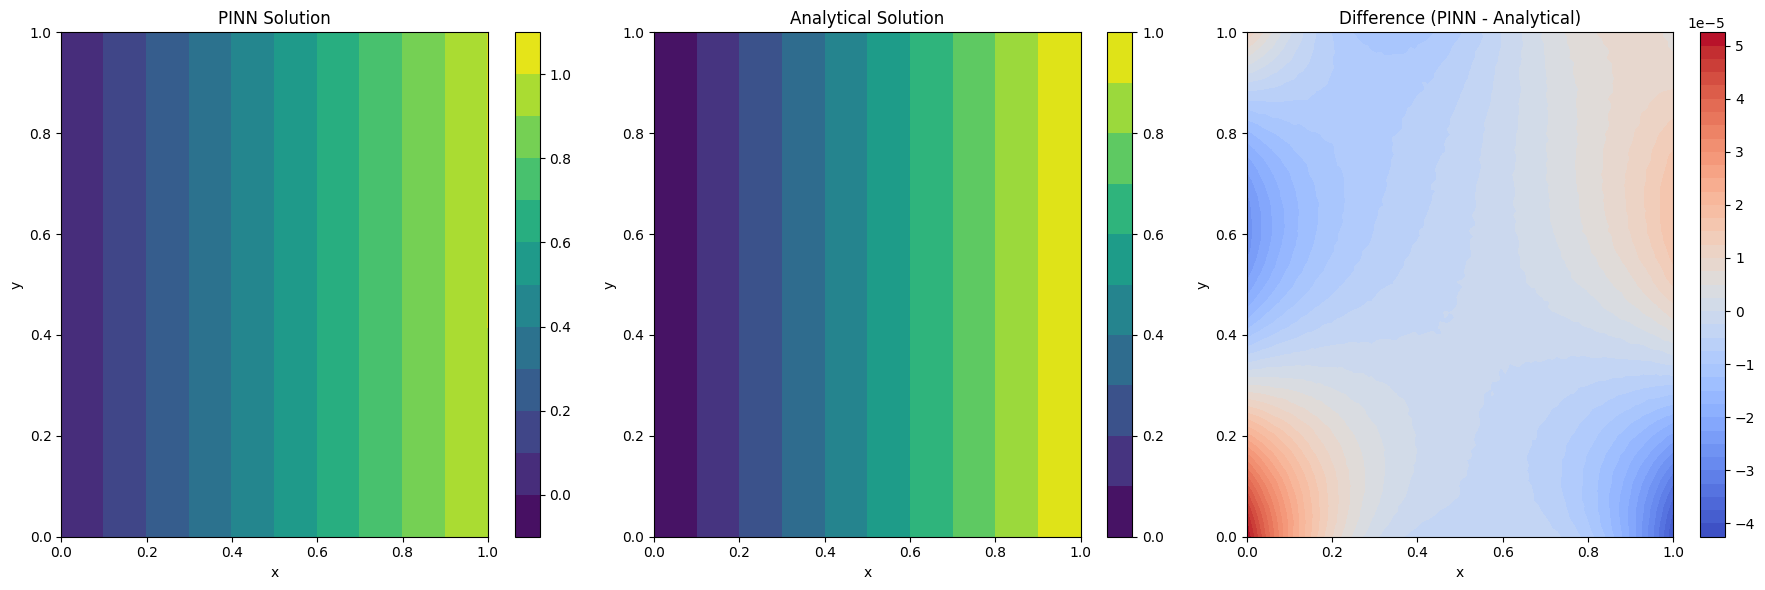

Maximum absolute difference: 5.206E-05, Mean absolute difference: 7.218E-06


In [449]:
# Define the grid
num = 100
x = y = torch.linspace(0, 1, num)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Assume `model` is your trained PINN model

# PINN solution
u_predicted = model(test_points).detach().numpy().reshape(num, num)  # Convert to numpy array for plotting

# Analytical solution
u_analytical = X.numpy()  # Linear solution u(x, y) = x, independent of y

# Difference between PINN solution and analytical solution
u_difference = u_predicted - u_analytical

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: PINN Solution
c1 = axs[0].contourf(X.numpy(), Y.numpy(), u_predicted, levels=10, cmap="viridis")
fig.colorbar(c1, ax=axs[0])
axs[0].set_title("PINN Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Plot 2: Analytical Solution
c2 = axs[1].contourf(X.numpy(), Y.numpy(), u_analytical, levels=10, cmap="viridis")
fig.colorbar(c2, ax=axs[1])
axs[1].set_title("Analytical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Plot 3: Difference (PINN - Analytical)
c3 = axs[2].contourf(X.numpy(), Y.numpy(), u_difference, levels=40, cmap="coolwarm")
fig.colorbar(c3, ax=axs[2])
axs[2].set_title("Difference (PINN - Analytical)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")

plt.tight_layout()  # Adjust layout to reduce whitespace
plt.show()

print(f"Maximum absolute difference: {np.abs(u_difference).max():.3E}, Mean absolute difference: {np.abs(u_difference).mean():.3E}")


## Rekorder

#### Optimizer = Adam

Maximum absolute difference: 6.852E-04, Mean absolute difference: 1.044E-04
Parametere:
- Epochs = 5001
- Size= 20*4
- Activation = tanH
- lr= 0.001
- Domain_points = 1000
- Boundary_points = 100
- Lambda laplace, dirichtlet, neumann = 1, 1, 1

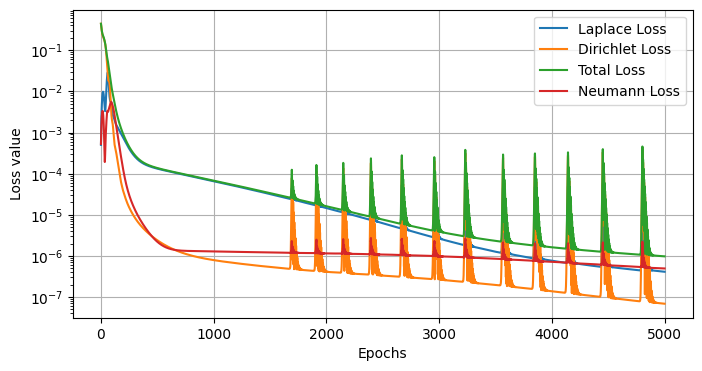

### Optimizer = LBFGS

- Max_iter=20
Maximum absolute difference: 5.156E-05, Mean absolute difference: 6.996E-06
Parametere:
- Epochs = 75
- Size= 64*3
- Activation = tanH
- lr= 0.1
- Domain_points = 1000
- Dirichlet_points = 1000
- Neumann_points = 1000
- Lambda laplace, dirichtlet, neumann = 10000, 500, 500

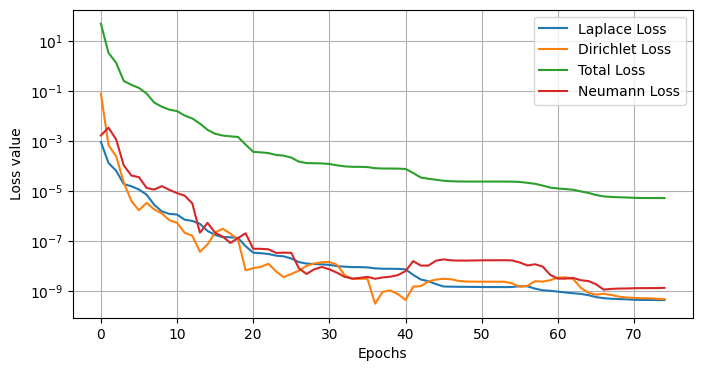

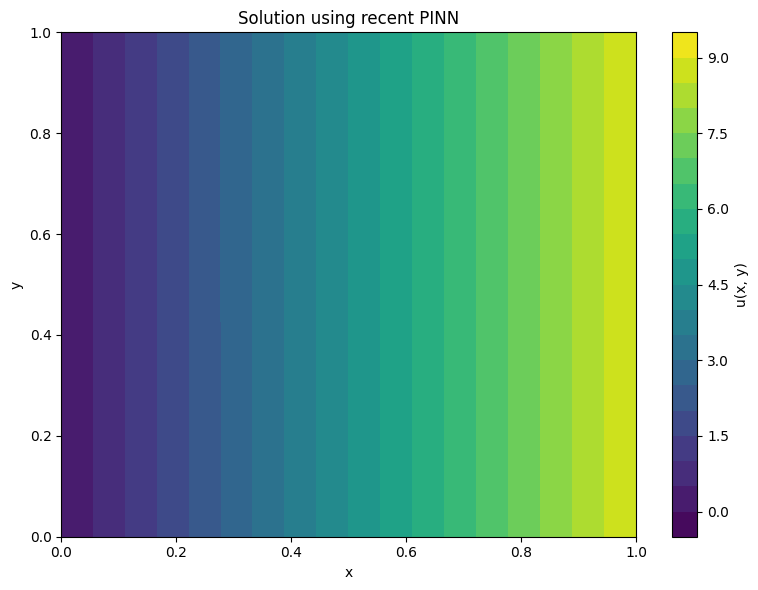

In [414]:
# Plot the results
num=1000
x = y = torch.linspace(0, 1, num)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# PINN solution
predicted_u = model(test_points).detach().numpy().reshape(num, num) #detach, numpy are used to convert the tensor to numpy array, reshape to coordinates.

plt.figure(figsize=(8, 6))

# PINN solution plot
plt.contourf(X.numpy(), Y.numpy(), predicted_u, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution using recent PINN")

plt.tight_layout()
plt.show()

A more advanced problem with more challanging boundaries:

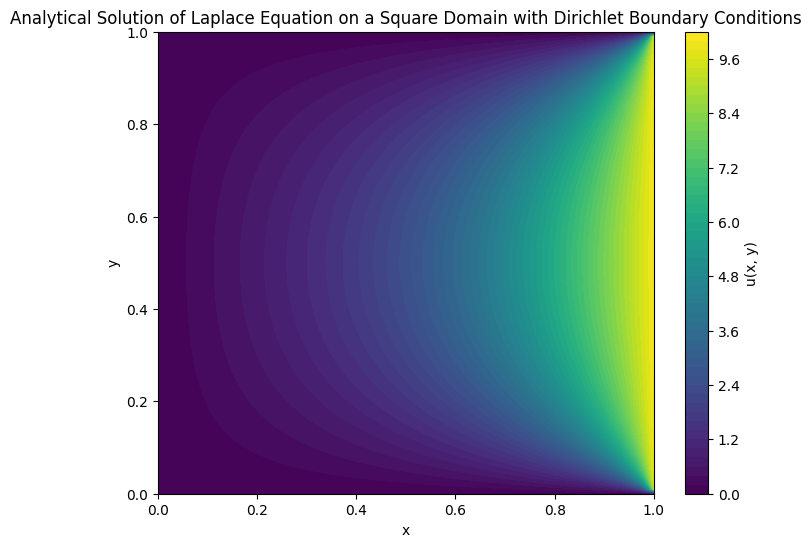

In [416]:
def analytical_solution_dirichlet_square(x, y, U=1.0, L=1.0, num_terms=100):
    """
    Computes the analytical solution of the Laplace equation on a square domain
    with Dirichlet boundary conditions on all sides: fixed potential on the top boundary, zero elsewhere.

    Parameters:
        x (np.ndarray): x-coordinates (2D array)
        y (np.ndarray): y-coordinates (2D array)
        U (float): Potential difference (default is 1.0 for top boundary)
        L (float): Side length of the square (default is 1.0)
        num_terms (int): Number of terms in the series for approximation (default is 100)

    Returns:
        np.ndarray: Analytical solution for u(x, y) on the given grid
    """
    u = np.zeros_like(x)
    for n in range(num_terms):
        term = (1 / (2 * n + 1)) * \
               (np.sinh((2 * n + 1) * np.pi * x / L) / np.sinh((2 * n + 1) * np.pi)) * \
               np.sin((2 * n + 1) * np.pi * y / L)
        u += term
    u *= (4 * U / np.pi)
    return u

# Define grid
L = 1.0
Nx, Ny = 100, 100
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

# Compute solution
U = 10.0
u = analytical_solution_dirichlet_square(X, Y, U=U, L=L, num_terms=100)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u, 50, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution of Laplace Equation on a Square Domain with Dirichlet Boundary Conditions")
plt.show()

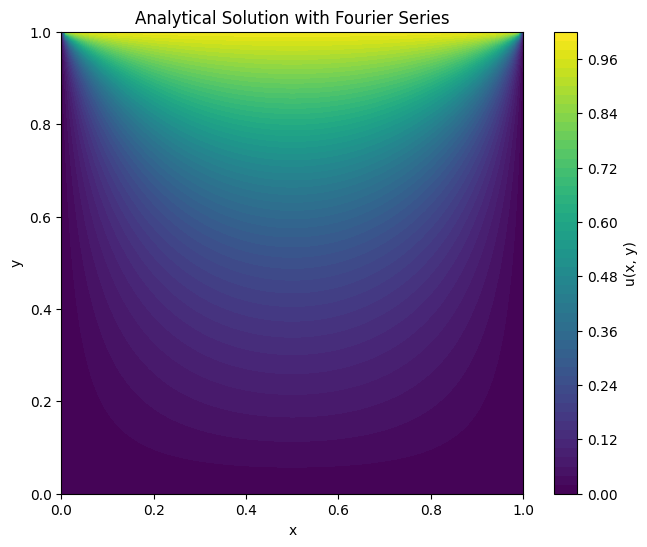

In [417]:
import numpy as np
import matplotlib.pyplot as plt

# Domain
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Analytical solution using multiple terms in the Fourier series
u = np.zeros_like(X)
num_terms = 200  # Increase for higher accuracy

for n in range(1, num_terms + 1, 2):  # Sum over odd terms
    term = (4 / (np.pi * n)) * np.sin(n * np.pi * X) * np.sinh(n * np.pi * Y) / np.sinh(n * np.pi)
    u += term

# Plotting the solution
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, u, levels=50, cmap="viridis")
plt.colorbar(cp, label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution with Fourier Series")

# Set equal aspect ratio and limits
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()


## Simple example with stationary flow

Epoch 0, Total Loss: 5.457E+02, Domain Loss: 3.809E-04, Boundary Loss Dirichlet: 5.431E-01


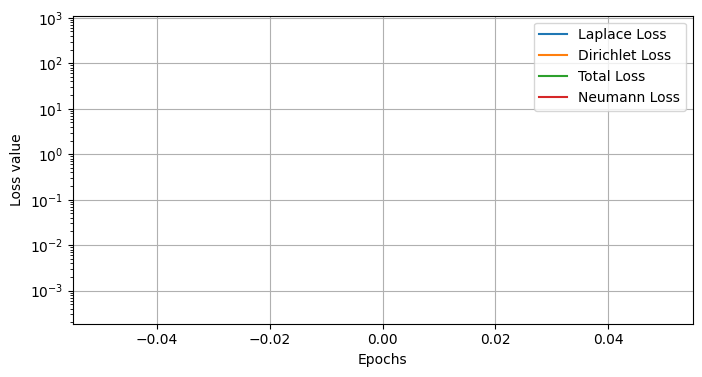

Epoch 1000, Total Loss: 7.739E+00, Domain Loss: 7.721E-03, Boundary Loss Dirichlet: 6.175E-03


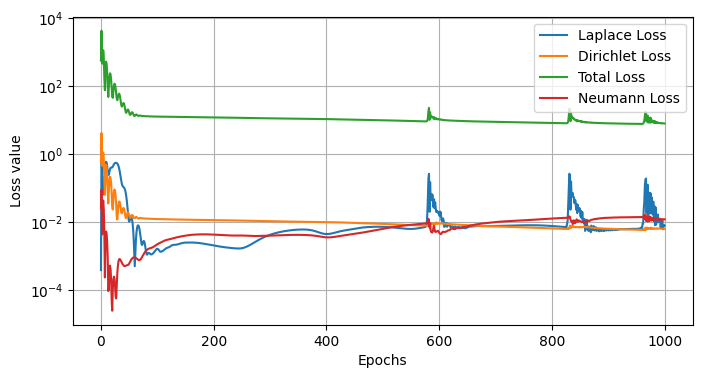

Epoch 2000, Total Loss: 6.674E+00, Domain Loss: 4.367E-03, Boundary Loss Dirichlet: 4.668E-03


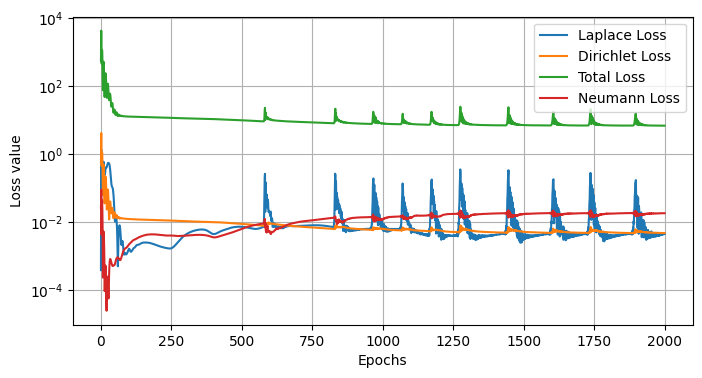

In [ ]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points
    
def plot_losses(epochs, laplace_losses, dirichlet_losses, neumann_losses, total_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, laplace_losses, label="Laplace Loss")
    plt.plot(epochs, dirichlet_losses, label="Dirichlet Loss")
    plt.plot(epochs, total_losses, label="Total Loss")
    plt.plot(epochs, neumann_losses, label="Neumann Loss")
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()
#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 0.2

# Boundary points and targets storage
boundary_points_dirichlet = []
boundary_target_dirichlet = []
boundary_points_neumann = []

# Dirichlet boundary conditions
dirichlet_boundaries = [
    ('vertical', left, 0, top, 1000, 1),  # Left boundary
    ('vertical', right, 0, top, 1000, 0),  # Right boundary
    # ('horizontal', bottom, 0, right, 1000, 1),  # Bottom boundary
    ('horizontal', top, 0, 0.3*right, 1000, 1),   # Top boundary]
    ('horizontal', top, 0.7*right, 1*right, 1000, 0)   # Top boundary
]

for axis, place, start, end, num_points, head in dirichlet_boundaries:
    boundary_points, boundary_targets = create_boundary_points(axis, place, start, end, num_points, head)
    boundary_points_dirichlet.append(boundary_points)
    boundary_target_dirichlet.append(boundary_targets)

# Concatenate Dirichlet boundary points and targets
boundary_points_dirichlet = torch.cat(boundary_points_dirichlet, dim=0).requires_grad_(True)
boundary_target_dirichlet = torch.cat(boundary_target_dirichlet, dim=0)

# Neumann boundary conditions
neumann_boundaries = [
    # ('vertical', left, 0, top, 100),  # Left boundary
    # ('vertical', right, 0, top, 100),  # Right boundary
    ('horizontal', bottom, 0, right, 1000),  # Bottom boundary
    ('horizontal', top, 0.3*right, 0.7*right, 1000)   # Top boundary
]

for axis, place, start, end, num_points in neumann_boundaries:
    boundary_points_n = create_boundary_points(axis, place, start, end, num_points)
    boundary_points_neumann.append(boundary_points_n)

# Concatenate Neumann boundary points
boundary_points_neumann = torch.cat(boundary_points_neumann, dim=0).requires_grad_(True)

# Creating domain points
num_domain_points=1000
x_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
x = (x_points*right).requires_grad_(True)
y_points = torch.rand(num_domain_points,1) #Need to be changed to the actual domain
y=(y_points*top).requires_grad_(True)
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses = []
neumann_losses = []
total_losses = []
epochs_recorded = []



#Defining changeable parameters:
model=pinn(hidden_size=128, hidden_layers=3) # to be used for evaluating u at boundaries and inside the domain
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,amsgrad=True) #Using the Adam optimizer
lambda_laplace, lambda_dirichlet, lambda_neumann = 50,1000,100  #Weights for the losses
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)
epochs=2001

#Training loop:
for epoch in range(epochs):
    optimizer.zero_grad() #Have to zero the gradients at the start of each epoch
    # optimizer.zero_grad() #Have to zero the gradients at the start of each epoch
    
    # # # def closure():
    # # #     optimizer.zero_grad()  # Clear previous gradients
    # # #     loss_laplace = laplace_residual(model, train_points)
    # # #     loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
    # # #     loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')

    # # #     # Add other boundary losses if needed
    # # #     total_loss =loss_laplace * lambda_laplace  + loss_dirichlet * lambda_dirichlet + loss_neumann * lambda_neumann
        
    # # #     total_loss.backward()  # Compute gradients
    # # #     return total_loss

    # # # # Step with LBFGS, passing in the closure

    # # # optimizer.step(closure)

    #losses
    loss_laplace=laplace_residual(model,train_points)
    loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
    loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')
    loss = loss_dirichlet * lambda_dirichlet + loss_laplace * lambda_laplace + loss_neumann * lambda_neumann
    # Backward pass
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #Clipping the gradients
    optimizer.step() # Update

    # Append losses to the lists
    laplace_losses.append(loss_laplace.item()) 
    dirichlet_losses.append(loss_dirichlet.item())
    neumann_losses.append(loss_neumann.item())
    total_losses.append(loss.item())
    epochs_recorded.append(epoch) 

    # scheduler.step(loss)

    # Logging
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.3E}, Domain Loss: {loss_laplace.item():.3E}, Boundary Loss Dirichlet: {loss_dirichlet.item():.3E}")
        plot_losses(epochs_recorded, laplace_losses, dirichlet_losses, neumann_losses, total_losses)

In [106]:
print(loss)

tensor(1.0903e+08, grad_fn=<MulBackward0>)


In [1]:
# Define the grid
num = 100
x = torch.linspace(0, right, num)
y=torch.linspace(0, top, num)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Assume `model` is your trained PINN model

# PINN solution
u_predicted = model(test_points).detach().numpy().reshape(num, num)  # Convert to numpy array for plotting

# Analytical solution
u_analytical = 1/right*X.numpy()  # Linear solution u(x, y) = x, independent of y

# Difference between PINN solution and analytical solution
u_difference = u_predicted - u_analytical

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: PINN Solution
c1 = axs[0].contourf(X.numpy(), Y.numpy(), u_predicted, levels=10, cmap="viridis")
fig.colorbar(c1, ax=axs[0])
axs[0].set_title("PINN Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Plot 2: Analytical Solution
c2 = axs[1].contourf(X.numpy(), Y.numpy(), u_analytical, levels=10, cmap="viridis")
fig.colorbar(c2, ax=axs[1])
axs[1].set_title("Analytical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Plot 3: Difference (PINN - Analytical)
c3 = axs[2].contourf(X.numpy(), Y.numpy(), u_difference, levels=40, cmap="coolwarm")
fig.colorbar(c3, ax=axs[2])
axs[2].set_title("Difference (PINN - Analytical)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")

plt.tight_layout()  # Adjust layout to reduce whitespace
plt.show()

print(f"Maximum absolute difference: {np.abs(u_difference).max():.3E}, Mean absolute difference: {np.abs(u_difference).mean():.3E}")


NameError: name 'torch' is not defined

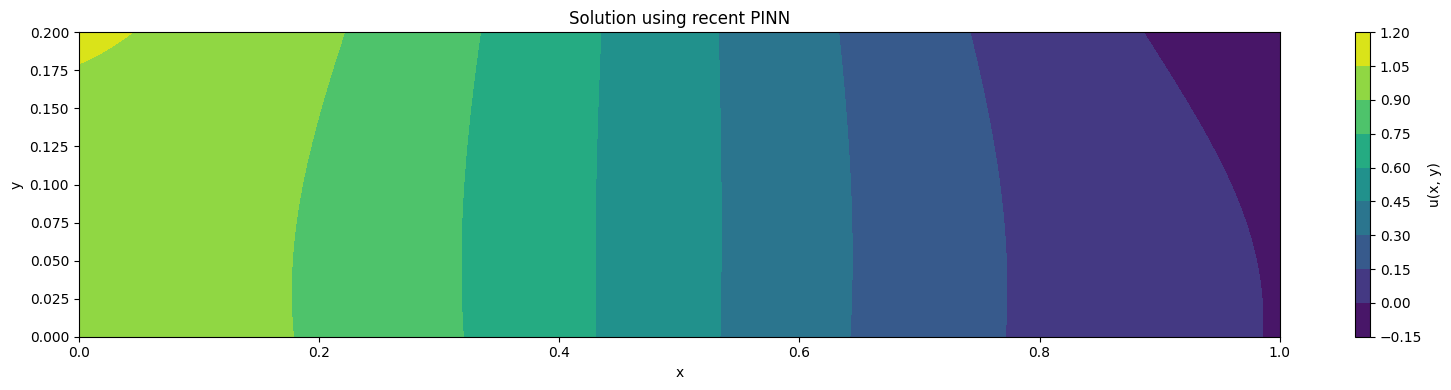

In [24]:
# Plot the results
num=100
x = torch.linspace(0, right, 600)
y=torch.linspace(0, top, 200)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# PINN solution
predicted_u = model(test_points).detach().numpy().reshape(600, 200) #detach, numpy are used to convert the tensor to numpy array, reshape to coordinates.

plt.figure(figsize=(16, 4))

# PINN solution plot
plt.contourf(X.numpy(), Y.numpy(), predicted_u, 10, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution using recent PINN")

plt.tight_layout()
plt.show()

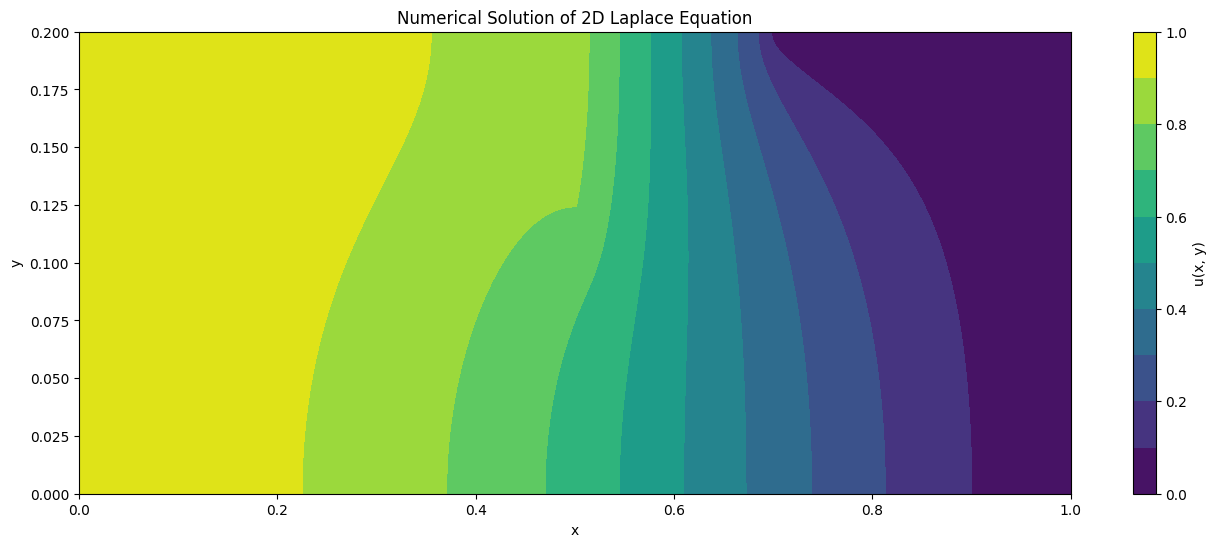

In [10]:
# Domain parameters
left, right, bottom, top = 0, 1, 0, 0.2
Lx, Ly = right,top  # Domain size in x and y
Nx, Ny = 300, 100  # Number of grid points
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing
tolerance = 1e-6  # Convergence tolerance

# Boundary conditions
def f(y): return 1  # u(0, y) = f(y)
def s(x): return 0  # u(x, 1) = q(x)

# Initialize the solution grid with zeros
u = np.zeros((Nx, Ny))

# Apply boundary conditions
u[0:int(0.3*Nx),-1] = f(np.linspace(0, Lx, Nx))  # Top boundary
u[int(0.7*Nx):Nx,-1] = s(np.linspace(0, Lx, Nx))  # Top boundary
u[0, :] = f(np.linspace(0, Ly, Ny))  # Left boundary
u[-1, :] = s(np.linspace(0, Ly, Ny))  # Right boundary

# Neumann condition (no flow) on the top and bottom boundaries
u[int(0.3*Nx):int(0.7*Nx), -1] = u[int(0.3*Nx):int(0.7*Nx), -2]    # Top boundary, ∂u/∂y = 0
u[0:Nx, 0] = u[0:Nx, 1]      # Bottom boundary, ∂u/∂y = 0
u[int(0.5*Nx), int(0.5*Ny):Ny] = u[int(0.5*Nx)+1, int(0.5*Ny):Ny]
u[int(0.5*Nx), int(0.5*Ny):Ny] = u[int(0.5*Nx)-1, int(0.5*Ny):Ny]

# Iterative solution using the finite difference method
error = 1.0  # Initialize error
while error > tolerance:
    u_old = u.copy()
    
    # Update the interior points using the finite difference scheme
    u[1:-1, 1:-1] = 0.25 * (u_old[2:, 1:-1] + u_old[:-2, 1:-1] +
                            u_old[1:-1, 2:] + u_old[1:-1, :-2])

    # Neumann condition (no flow in x-direction at x = 1): ∂u/∂x = 0
    u[int(0.3*Nx):int(0.7*Nx), -1] = u[int(0.3*Nx):int(0.7*Nx), -2]    # Top boundary, ∂u/∂y = 0
    u[0:Nx, 0] = u[0:Nx, 1]      # Bottom boundary, ∂u/∂y = 0
    u[int(0.5*Nx), int(0.5*Ny):Ny] = u[int(0.5*Nx)+1, int(0.5*Ny):Ny]
    u[int(0.5*Nx), int(0.5*Ny):Ny] = u[int(0.5*Nx)-1, int(0.5*Ny):Ny]

    # Compute the error as the maximum difference between old and new values
    error = np.max(np.abs(u - u_old))

# Plot the results
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
plt.figure(figsize=(16, 6))
plt.contourf(X, Y, u.T, 10, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical Solution of 2D Laplace Equation")
plt.show()

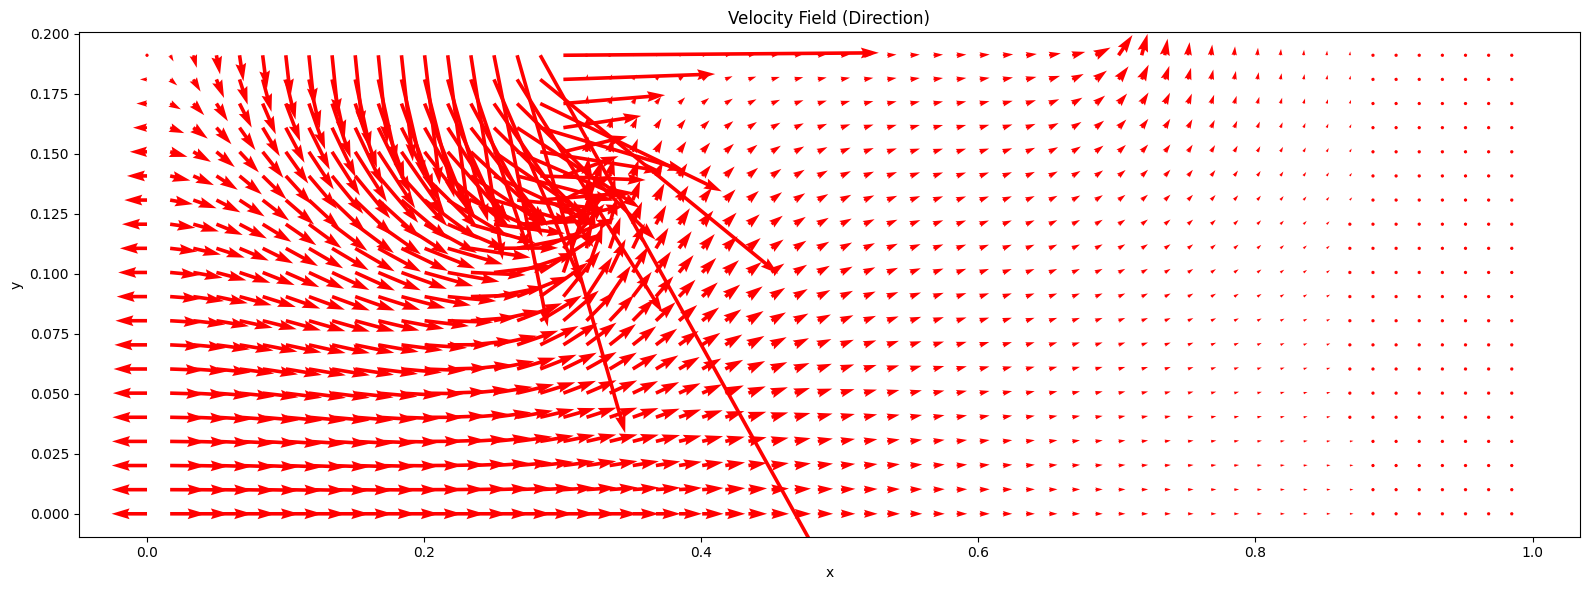

In [65]:
# Define the downsampling rate for the arrows
pil_x = 60  # Number of arrows in x and y directions
pil_y = 20 # Number of arrows in x and y directions
K=1

# Compute velocity field (v_x and v_y) from the gradient of u
v_x = np.zeros_like(u)
v_y = np.zeros_like(u)

# Central differences for interior points
v_x[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2 * dx)
v_y[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * dy)

# Forward/backward differences for boundaries
v_x[0, :] = -K*(u[1, :] - u[0, :]) / dx  # Left boundary
v_x[-1, :] = -K*(u[-1, :] - u[-2, :]) / dx  # Right boundary
v_y[:, 0] = -K*(u[:, 1] - u[:, 0]) / dy  # Bottom boundary
v_y[:, -1] = -K*(u[:, -1] - u[:, -2]) / dy  # Top boundary

# Full grid for plotting the potential field
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))

# Downsample for arrow plotting
step_x = Nx // pil_x
step_y = Ny // pil_y
X_downsampled = X[::step_x, ::step_y]
Y_downsampled = Y[::step_x, ::step_y]
v_x_downsampled = v_x[::step_x, ::step_y]
v_y_downsampled = v_y[::step_x, ::step_y]

# Plot the potential field
plt.figure(figsize=(16, 6))

# Plot the velocity field (direction and magnitude) on downsampled grid
plt.quiver(X_downsampled, Y_downsampled, -v_x_downsampled.T, -v_y_downsampled.T, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Velocity Field (Direction)")

plt.tight_layout()
plt.show()

In [ ]:
print(u[int(0.3*Nx), int(0.5*Ny):Ny] - u[int(0.3*Nx)+1, int(0.5*Ny):Ny])

In [ ]:
# Load the saved data
u_saved='u_saved.npy'
u_FDM= np.load(u_saved)


In [36]:
# Domain parameters
left, right, bottom, top = 0, 1, 0, 0.3
Lx, Ly = right,top  # Domain size in x and y
Nx, Ny = 600, 200  # Number of grid points

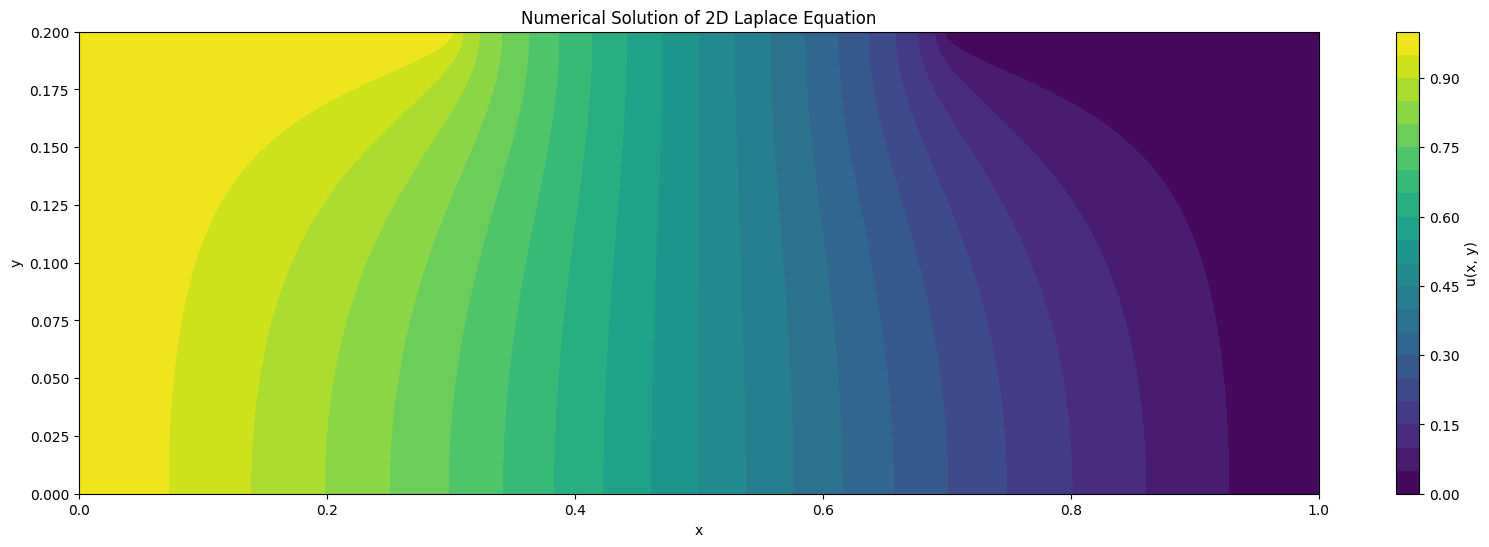

In [66]:
# Plot the results
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
plt.figure(figsize=(20, 6))
plt.contourf(X, Y, u_FDM.T, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical Solution of 2D Laplace Equation")
plt.show()

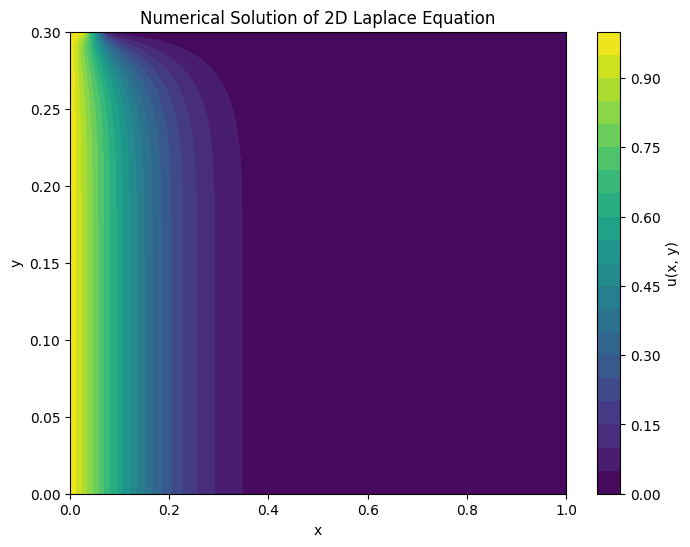

In [13]:
# Plot the results
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u.T, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical Solution of 2D Laplace Equation")
plt.show()

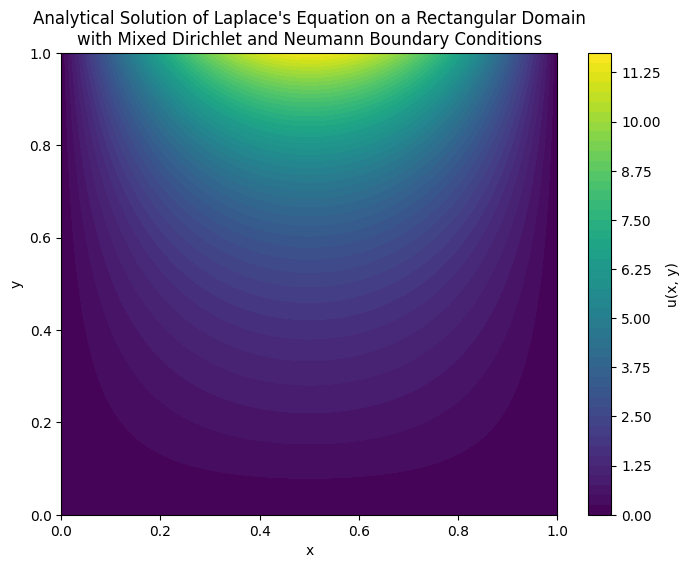

In [434]:
import numpy as np
import matplotlib.pyplot as plt

# Define the domain
L, H = 1, 1  # Length of the rectangle in x and y directions
num_points = 100

x = np.linspace(0, L, num_points)
y = np.linspace(0, H, num_points)
X, Y = np.meshgrid(x, y)

# Define the analytical solution
U = np.sinh(np.pi * Y / L) * np.sin(np.pi * X / L)

# Plot the analytical solution
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, U, levels=50, cmap="viridis")
plt.colorbar(cp, label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution of Laplace's Equation on a Rectangular Domain\n"
          "with Mixed Dirichlet and Neumann Boundary Conditions")
plt.show()


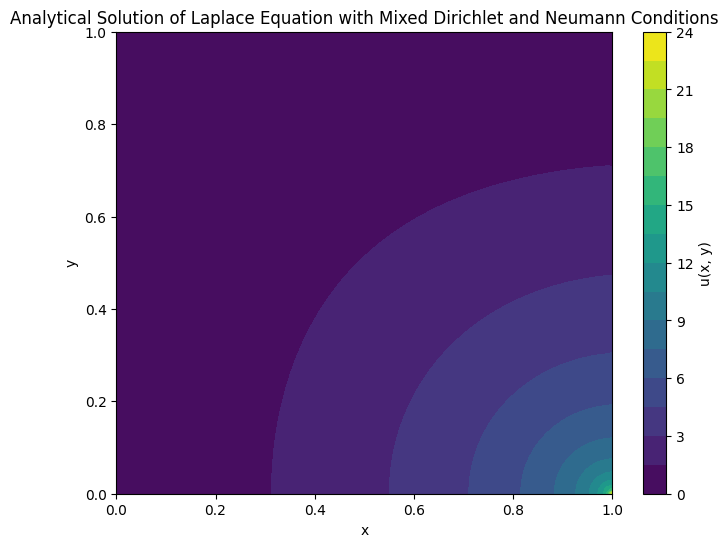

0.0
Maximum value in u is located at index: (0, 99)


In [418]:
import numpy as np
import matplotlib.pyplot as plt

def analytical_solution_mixed_boundaries(x, y, U=1.0, L=1.0, W=1.0, num_terms=50):
    """
    Computes the analytical solution of the Laplace equation on a rectangular domain
    with Dirichlet boundary conditions on the left and right, and Neumann boundary conditions on the top and bottom.

    Parameters:
        x (np.ndarray): x-coordinates (2D array)
        y (np.ndarray): y-coordinates (2D array)
        U (float): Potential on the right boundary (default is 1.0)
        L (float): Width of the rectangle in the x direction
        W (float): Height of the rectangle in the y direction
        num_terms (int): Number of terms in the series for approximation (default is 50)

    Returns:
        np.ndarray: Analytical solution for u(x, y) on the given grid
    """
    u = np.zeros_like(x)
    for n in range(num_terms):
        A_n = (4 * U) / (np.pi * (2 * n + 1))
        term = A_n * np.cos((2 * n + 1) * np.pi * y / (2 * W)) * \
               (np.sinh((2 * n + 1) * np.pi * x / (2 * W)) / np.sinh((2 * n + 1) * np.pi * L / (2 * W)))
        u += term
    return u

# Set up the domain
L, W = 1.0, 1.0  # Domain dimensions
Nx, Ny = 100, 100  # Number of points in x and y directions
x = np.linspace(0, L, Nx)
y = np.linspace(0, W, Ny)
X, Y = np.meshgrid(x, y)

# Compute the solution
U = 5.0
u = analytical_solution_mixed_boundaries(X, Y, U=U, L=L, W=W, num_terms=200)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution of Laplace Equation with Mixed Dirichlet and Neumann Conditions")
plt.show()
print((u[1,0]))
max_index = np.unravel_index(np.argmax(u, axis=None), u.shape)
print(f"Maximum value in u is located at index: {max_index}")

In [419]:
ind = find(M:):
L=L(ind,ind)
n=b(ind)
u=L/b
U=zeros(Nx,Ny)|
U(ind)=u


SyntaxError: invalid syntax (2359077380.py, line 1)

### Problem Setup

1. **Domain**:
   - **Depth**: 10 meters (from ground surface to bedrock).
   - **Excavation Depth**: 4 meters deep, with water pumped out to the bottom level of the pit.
   - **Width of Domain**: 2.5 meters (using symmetry for the 5-meter width of the pit).

2. **Boundary Conditions**:
   - **Ground Surface Boundary (Outside the Pit)**: Water head is set to the ground surface level (10 meters).
   - **Excavation Pit Floor**: Water head inside the excavation pit is at the bottom of the pit, so 4 meters below the surface.
   - **Sheet Pile Wall (Impermeable Boundary)**: This boundary goes down 6 meters, creating a no-flow condition along this section.
   - **Bedrock (Impermeable)**: The bedrock at 10 meters depth is also impermeable, leading to a no-flow condition.

3. **Symmetry Boundary Condition**:
   - Along the symmetry line (middle of the pit), there is no lateral flow, which results in a no-flow (Neumann) boundary condition.


### Boundary Conditions

1. **Ground Surface Boundary (Outside the Pit)**: 
   - The water head is set to the ground surface level, which is 10 meters.
   - Boundary condition: $u(x, 0) = 10$.

2. **Excavation Pit Floor**: 
   - The water head inside the excavation pit is at the bottom of the pit, 4 meters below the surface.
   - Boundary condition: $u(x, -4) = 4$.

3. **Sheet Pile Wall (Impermeable Boundary)**: 
   - The wall extends down to 6 meters, creating a no-flow condition along this section.
   - Boundary condition: $\frac{\partial u}{\partial x} = 0$ along the wall from 0 to 6 meters depth.

4. **Bedrock (Impermeable)**: 
   - The bedrock at 10 meters depth is impermeable, leading to a no-flow condition.
   - Boundary condition: $\frac{\partial u}{\partial y} = 0$ at 10 meters depth.

5. **Symmetry Boundary Condition**: 
   - Along the symmetry line (middle of the excavation pit), there is no lateral flow, resulting in a no-flow condition.
   - Boundary condition: $\frac{\partial u}{\partial x} = 0$ along the symmetry boundary.



In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 8))

# Define coordinates for different regions and boundaries
# Excavation pit
excavation_depth = -4
pit_width_half = 2.5  # Half-width due to symmetry

# Bedrock depth
bedrock_depth = -10

# Sheet pile wall
sheet_pile_depth = -6
sheet_pile_x = pit_width_half

# Water levels
water_outside = 0  # Groundwater level outside the pit
water_inside = -4    # Groundwater level inside the pit at bottom of excavation

# Draw bedrock line
ax.plot([0, 7.5], [bedrock_depth, bedrock_depth], color='black', linestyle='--', label='Bedrock (No-flow)')

# Draw excavation pit walls and bottom
ax.plot([pit_width_half, -pit_width_half], [excavation_depth, excavation_depth], color='blue', label='Excavation Pit Floor (Water Head = 4m)')

# Draw water level outside
ax.plot([2.5, 2.5-bedrock_depth], [0, 0], color='blue', linestyle='-', label='Water Head = 10m Outside')

# Draw sheet pile wall
ax.plot([sheet_pile_x, sheet_pile_x], [0, sheet_pile_depth], color='brown', linestyle='-', label='Sheet Pile Wall (No-flow)')

# Draw symmetry line (no-flow boundary)
ax.plot([0, 0], [0, bedrock_depth], color='green', linestyle='--', label='Symmetry Line (No-flow)')

# Labels
ax.set_title("Cross-Section of Excavation Pit with Boundary Conditions")
ax.set_xlabel("Width (meters)")
ax.set_ylabel("Depth (meters)")
ax.set_xlim(-.5, 2.5-bedrock_depth)
ax.set_ylim(bedrock_depth, 1)

# Add legend
ax.legend(loc='lower right')

# Show the plot
plt.show()
